# Facility location example

For assignment and data, see https://www.fransderuiter.com/JADS/

***

### Setup

In [1]:
import numpy as np
import pandas as pd
from pyomo.environ import *
import matplotlib.pyplot as plt
from matplotlib import cm

### Read data

In [2]:
data_path = "https://www.fransderuiter.com/JADS/Facilitylocation/FacilityLocation.xlsx"
# Create pandas table
distances = pd.read_excel(data_path, sheet_name=0, header=0, skiprows=2, index_col=1)

# Show table
distances.head()

,Unnamed: 0,Amsterdam,Antwerp,Athens,Barcelona,Berlin,Bern,Brussels,Calais,Cologne,...,Prague,Rome,Rotterdam,Strasbourg,Stuttgart,The Hague,Turin,Venice,Vienna,Zurich
Distance (km),,,,,,,,,,,,,,,,,,,,,
Amsterdam,NaN,0,160,3082,1639,649,875,209,385,280,...,973,1835,80,683,703,56,1264,1449,1196,861
Antwerp,NaN,160,0,2766,1465,723,704,46,211,237,...,870,1660,100,544,659,139,1090,1275,1180,687
Athens,NaN,3082,2766,0,3312,2552,2627,3021,2976,2562,...,2198,2551,2826,2581,2428,3061,2250,1995,1886,2449
Barcelona,NaN,1639,1465,3312,0,1899,913,1419,1399,1539,...,1679,1471,1565,1072,1263,1589,892,1327,1989,1036
Berlin,NaN,649,723,2552,1899,0,986,782,936,575,...,354,1573,697,801,636,712,1172,1108,666,863


In [3]:
#remove 1st column ('unnamed', because there is a comment in first column it was added)
distances = distances.drop(distances.columns[0],1)

# Show table with removed column
distances.head()

,Amsterdam,Antwerp,Athens,Barcelona,Berlin,Bern,Brussels,Calais,Cologne,Copenhagen,...,Prague,Rome,Rotterdam,Strasbourg,Stuttgart,The Hague,Turin,Venice,Vienna,Zurich
Distance (km),,,,,,,,,,,,,,,,,,,,,
Amsterdam,0,160,3082,1639,649,875,209,385,280,904,...,973,1835,80,683,703,56,1264,1449,1196,861
Antwerp,160,0,2766,1465,723,704,46,211,237,861,...,870,1660,100,544,659,139,1090,1275,1180,687
Athens,3082,2766,0,3312,2552,2627,3021,2976,2562,3414,...,2198,2551,2826,2581,2428,3061,2250,1995,1886,2449
Barcelona,1639,1465,3312,0,1899,913,1419,1399,1539,2230,...,1679,1471,1565,1072,1263,1589,892,1327,1989,1036
Berlin,649,723,2552,1899,0,986,782,936,575,743,...,354,1573,697,801,636,712,1172,1108,666,863


In [4]:
## Show index names
cities = distances.columns
print(cities)

Index(['Amsterdam', 'Antwerp', 'Athens', 'Barcelona', 'Berlin', 'Bern',
       'Brussels', 'Calais', 'Cologne', 'Copenhagen', 'Edinburgh', 'Frankfurt',
       'Geneva', 'Genoa', 'Hamburg', 'Le Havre', 'Lisbon', 'London',
       'Luxembourg', 'Lyon', 'Madrid', 'Marseille', 'Milan', 'Munich',
       'Naples', 'Nice', 'Paris', 'Prague', 'Rome', 'Rotterdam', 'Strasbourg',
       'Stuttgart', 'The Hague', 'Turin', 'Venice', 'Vienna', 'Zurich'],
      dtype='object')


### Model parameters

In [5]:
# Fixed cost for opening a DC (same for each city)
fixed_cost = 150000 #150000

# demand equals 100 for each city
demand_per_city = 100

# Supply capacity of each city is 4000
M = 4000

# Create pandas dataframe with supply
city_params_dict = {'supply': M*np.ones(cities.size, int), 
                    'demand': demand_per_city*np.ones(cities.size, int), 
                    'fixed cost': fixed_cost*np.ones(cities.size, int)}
city_params = pd.DataFrame(data=city_params_dict, index = cities)
city_params.head()

,supply,demand,fixed cost
Amsterdam,4000,100,150000
Antwerp,4000,100,150000
Athens,4000,100,150000
Barcelona,4000,100,150000
Berlin,4000,100,150000


Advanced side remark for the interested reader:

For $M$ we could have chosen any value larger than the sum of the total demand (3700), as we will never send 4000 from one hub. $M$ is used in the so-called "big-M" method. Here a binary variable (DC open yes/no) is used to say that another variable is either 0, or can be any continuous value. The trick with larger models is to take $M$ as small as possible without limiting the continuous value. This makes the integer optimization algorithm much more efficient.

### Model implementation

In [9]:
# Create model
m = ConcreteModel()

# Variables
m.locations = Var(cities, within=Binary)
m.shipments = Var(cities, cities, within = NonNegativeReals)

# Objective
m.value = Objective(
    expr=sum(m.shipments[i,j]*distances[i][j] for i in cities for j in cities)
    + sum(m.locations[i]*city_params.loc[i,'fixed cost'] for i in cities)
    , sense=minimize
             )

# Constraints on demand fulfillment
m.demand_fulfillment = ConstraintList()
for i in cities:
    m.demand_fulfillment.add(sum(m.shipments[j,i] for j in cities) == city_params.loc[i,'demand'])
    
# Constraints on supply only if DC is open
m.supply_restriction = ConstraintList()
for i in cities:
    m.supply_restriction.add(sum(m.shipments[i,j] for j in cities) <= m.locations[i]*city_params.loc[i,'supply'])

### Solve the model

In [10]:
# Optimize
solver = SolverFactory('cbc') # Take the cbc solver, glpk is very slow
status = solver.solve(m,tee=False,) # Set tee to True to see log of the solver

# Print the status of the solved mixed integer linear model once it is done
print("Status = %s \n" % status.solver.termination_condition)

Status = optimal 



### Show the solution

In [11]:
print("Total optimized cost \t = %.3f MEuro" % (value(m.value)/1e6))
print("\t Fixed cost \t = %.3f MEuro" % (sum([value(m.locations[i]*city_params.loc[i,'fixed cost']) for i in cities])/1e6))
print("\t Shipment costs  = %.3f MEuro\n" % (sum(value(m.shipments[i,j])*distances[i][j] for i in cities for j in cities)/1e6))

print("Total DCs opened = %d\n" % sum([value(m.locations[i]) for i in cities]))
print("DC open:")
for i in cities:
    if value(m.locations[i] == 1):
        print("\t-"+i)

Total optimized cost 	 = 2.019 MEuro
	 Fixed cost 	 = 0.750 MEuro
	 Shipment costs  = 1.269 MEuro

Total DCs opened = 5

DC open:
	-Antwerp
	-Athens
	-Madrid
	-Munich
	-Turin


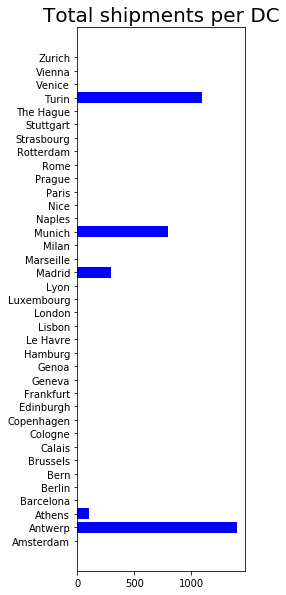

In [12]:
totalshipments = [sum(value(m.shipments[i,j]) for i in cities) for j in cities]

plt.figure(figsize=(3,10))
plt.barh(range(cities.size),totalshipments, color="blue",align="center")
plt.yticks(range(cities.size),cities,rotation=0)
plt.title('Total shipments per DC',fontsize=20)
plt.show()

### Some more visualization (not part of assignment)
This requires the installation of the packages geopy and basemap, which can be installed via: ``conda install geopy basemap``.

In [13]:
# Get lat and lon of cities via geocoder
from geopy.geocoders import Yandex  # Used for geocoding

geolocator = Yandex()               # Open source geocoder. This one seems to work well with only the city names.

coordinates = []

for i in cities:
    location = geolocator.geocode(i)
    coordinates.append([location.latitude, location.longitude])
    
df_coordinates = pd.DataFrame(coordinates, index=cities, columns=['latitude', 'longitude'])
df_coordinates.head()


,latitude,longitude
Amsterdam,52.372518,4.896977
Antwerp,51.220117,4.396364
Athens,37.975527,23.734855
Barcelona,41.387027,2.170024
Berlin,52.519881,13.407338


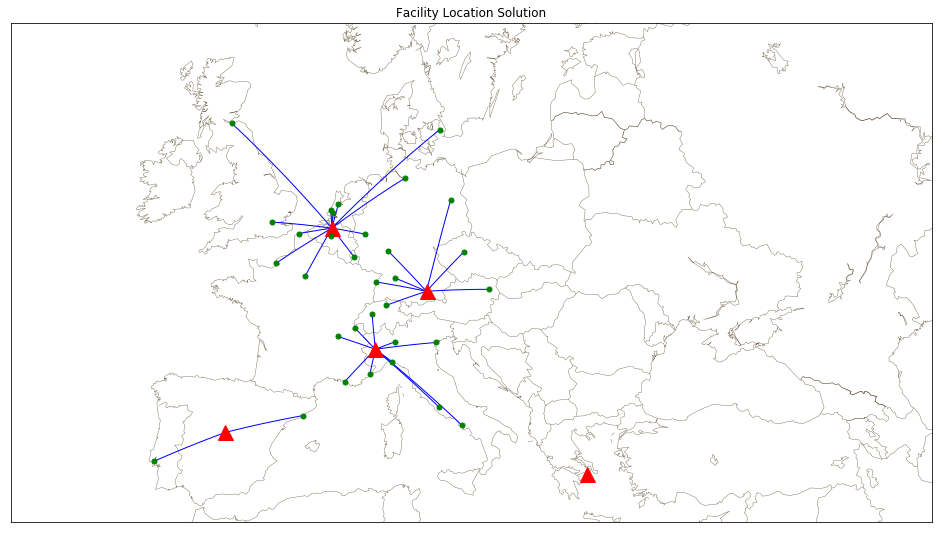

In [14]:
from mpl_toolkits.basemap import Basemap

# create new figure, axes instances.
fig=plt.figure(figsize=(16,24))
ax=fig.add_axes([0.1,0.1,0.8,0.8])

# setup mercator map projection.
map_europe = Basemap(llcrnrlon=-20.,llcrnrlat=35.,urcrnrlon=50.,urcrnrlat=60.,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',projection='merc',\
            lat_0=40.,lon_0=-20.,lat_ts=20.)

map_europe.fillcontinents(color='white')#,lake_color='#85A6D9')
map_europe.drawcoastlines(color='#6D5F47', linewidth=.4)
map_europe.drawcountries(color='#6D5F47', linewidth=.4)

# Drawing lines
for i in cities:
    for j in cities:
        if (value(m.shipments[i,j]) > 0):           
            olon = df_coordinates.loc[i,'longitude']
            olat = df_coordinates.loc[i,'latitude']
            dlon = df_coordinates.loc[j,'longitude']
            dlat = df_coordinates.loc[j,'latitude']
            
            # draw route between origin and destination
            map_europe.drawgreatcircle(olon,olat,dlon,dlat,linewidth=1,color='b')

# Drawing points
for i in cities:
    x, y = map_europe.projtran(df_coordinates.loc[i,'longitude'], df_coordinates.loc[i,'latitude'])  # Some transformation of coordinates that is needed
    if (value(m.locations[i]) > 0): # DC is open
        map_europe.plot(x, y, 'r^', markersize=15)
    else:
        map_europe.plot(x, y, 'go', markersize=5)
            
ax.set_title('Facility Location Solution')
plt.show()